<h1 style="text-align: center; color: #2980B9">Entrenamiento de modelos: Precio de viviendas</h1>

<h2 style="color: #3498DB">Siuación a resolver</h2>

El presente trabajo busca predecir el precio de venta de viviendas en India medido en lacs. Esto se hara entrenando modelos de machine learning que aprendan la relacion entre las caractersiticas y el target (precio en lacs) para poder estimar su precio de venta. Para ello es necesario aplicar tecnicas de feature engineering, clustering, transformacion, reduccion de dimesionalidad y tuneo de hiperparametros.

<h2 style="color: #3498DB">Importar Librerias</h2>

Se importan las librerias:<br>
-Pandas: Para manipular datos<br>
-Numpy:Para usar funciones matematicas avanzadas<br>
-Matplotlib: Para la creacion de visualizaciones<br>
-Seaborn: Para la creacion de visualizaciones<br>
<br>
Se importan las siguientes clases y funciones:<br>
-train_test_split: Para separar el dataset en datos de entrenamiento y testeo<br>
-GridSearchCV: Para buscar los mejores hiperametros<br>
-ColumnTransformer: Para aplicar diferentes transformaciones a diferentes columnas<br>
-KMeans: Es usado para agrupar las coordenadas de latitud y longitud<br>
Pipeline: Para encadenar los pasos de preprocesamiento y modelado<br>
OneHotEncoder: Para tranformar variables categoricas en numericas binarias<br>
StandardScaler: Para standarizar las columnas numericas<br>
-mean_absolute_error: Para calcular el MAE<br>
-mean_squared_error: Para calcular el RMSE<br>
-r2_score: Para calcular el R2<br>
<br>
Se importan los siguinetes modelos:<br>
-GradientBoostingRegressor<br>
-RandomForestRegressor<br>
-ExtraTreesRegressor<br>
-BaggingRegressor<br>

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor

<h2 style="color: #3498DB">Leer Dataset</h2>

Aqui leemos el archivo train.csv que contiene todos los datos necesarios para entrenar nuestro modelo. Ademas se visualizan las primeras lineas para evaluar el formato de los mismos.

In [104]:
df = pd.read_csv("train.csv")
df.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS)
0,Owner,0,0,2,BHK,1300.236407,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0
1,Dealer,0,0,2,BHK,1275.000000,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0
2,Owner,0,0,2,BHK,933.159722,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0
3,Owner,0,1,2,BHK,929.921143,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5
4,Dealer,1,0,2,BHK,999.009247,0,1,"New Town,Kolkata",22.592200,88.484911,60.5


<h2 style="color: #3498DB">Feature Engineering - Parte 1</h2>

Primero obtenemos la ciudad y el barrio de la varaible ADDRESS ya que esta en su formato actual no nos sirve para entrenar el modelo de machine learning. Luego creamos una nueva columna que indique de alguna manera la cantidad de espacio por habitacion dividiendo SQUARE_FT por BK_NO. A este resultado se le suma un 1 para evitar la division por 0 en caso de que BKH_NO. sea 0. Esta variable nos sirve para representar la densidad. Luego eliminamos la variable ADDRESS ya que obtuvimos los datos necesarios. Finalmente se le aplica una transformacion logaritmica a las variables SQUARE_FT y SQFT_PER_BHK ya que estan estan muy sesgadas (hay una concentracion de casas baratas y muy pocas casas con precios altos). Ademas se eliminan los outliers aplicando un rango intercuartil de 0.99.

In [105]:
df['CITY'] = df['ADDRESS'].str.split(',').str[-1].str.strip()
df['NEIGHBORHOOD'] = df['ADDRESS'].str.split(',').str[0].str.strip()
df['SQFT_PER_BHK'] = df['SQUARE_FT'] / (df['BHK_NO.'] + 1)

quantile_99 = df['TARGET(PRICE_IN_LACS)'].quantile(0.99)
df = df[df['TARGET(PRICE_IN_LACS)'] <= quantile_99]

df['SQUARE_FT'] = np.log1p(df['SQUARE_FT'])
df['SQFT_PER_BHK'] = np.log1p(df['SQFT_PER_BHK'])

df.head()

,POSTED_BY,UNDER_CONSTRUCTION,RERA,BHK_NO.,BHK_OR_RK,SQUARE_FT,READY_TO_MOVE,RESALE,ADDRESS,LONGITUDE,LATITUDE,TARGET(PRICE_IN_LACS),CITY,NEIGHBORHOOD,SQFT_PER_BHK
0,Owner,0,0,2,BHK,7.171070,1,1,"Ksfc Layout,Bangalore",12.969910,77.597960,55.0,Bangalore,Ksfc Layout,6.073994
1,Dealer,0,0,2,BHK,7.151485,1,1,"Vishweshwara Nagar,Mysore",12.274538,76.644605,51.0,Mysore,Vishweshwara Nagar,6.054439
2,Owner,0,0,2,BHK,6.839647,1,1,"Jigani,Bangalore",12.778033,77.632191,43.0,Bangalore,Jigani,5.743174
3,Owner,0,1,2,BHK,6.836175,1,1,"Sector-1 Vaishali,Ghaziabad",28.642300,77.344500,62.5,Ghaziabad,Sector-1 Vaishali,5.739708
4,Dealer,1,0,2,BHK,6.907765,0,1,"New Town,Kolkata",22.592200,88.484911,60.5,Kolkata,New Town,5.811150


<h2 style="color: #3498DB">Separar datos y variables</h2>

Aqui se divide el dataset en las caractersiticas en las usadas para entrenar el modelos y la variable objetivo. A la variable objetivo tambien se le aplica la transformacion logaritmica ya que es una variable sesgada.

In [106]:
X = df.drop(['TARGET(PRICE_IN_LACS)'], axis=1)
y = np.log1p(df['TARGET(PRICE_IN_LACS)'])

Aqui se dviden las variables segun su tipo en varaibles continuas, las que usaremos para OneHotEncoder y el resto.

In [107]:
variables_continuas = ['SQUARE_FT', 'LONGITUDE', 'LATITUDE', 'SQFT_PER_BHK']
variables_ohe = ['POSTED_BY', 'BHK_OR_RK', 'NEIGHBORHOOD', 'CITY']
variables_passthrough = ['UNDER_CONSTRUCTION', 'RERA', 'BHK_NO.', 'READY_TO_MOVE', 'RESALE']

Aqui separamos el dataset en los datos que usaremos para el entrenamiento del modelo y los datos para el testeo

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

<h2 style="color: #3498DB">Reduccion de Dimensionalidad</h2>

Si aplicamos OneHotEncoder directamente sobre CITY y NEIGHBORHOOD se crearian muchisimas nuevas columnas lo cual haria que el modelo sea lento e ineficiente. Para resolver esto reducimos la dimensionalidad de las variables a solo aquellas que tiene mas de 10 ocurrencias, al resto las nombraremos Other

In [109]:
ocurrencias = 10 
columnas = ['NEIGHBORHOOD', 'CITY']

for col in columnas:
    cantidad = X_train[col].value_counts()
    categorias_frecuentes = cantidad[cantidad >= ocurrencias].index
    
    X_train[col] = X_train[col].where(X_train[col].isin(categorias_frecuentes), 'Other')
    X_test[col] = X_test[col].where(X_test[col].isin(categorias_frecuentes), 'Other')

<h2 style="color: #3498DB">Clustering</h2>

Aqui aplicamos el algoritmo KMeans para formar grupos o en este caso zonas segun las coordenadas de las viviendas. Definimos el numero de clusters en 20, entrenamos el modelo, testeomos y aagregamos la nueva variable GEO_CLUSTER a la lista de variables que pasaran por OneHotEncoder. 

In [110]:
geo_cols = ['LONGITUDE', 'LATITUDE']
kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)

X_train['GEO_CLUSTER'] = kmeans.fit_predict(X_train[geo_cols]).astype(str)
X_test['GEO_CLUSTER'] = kmeans.predict(X_test[geo_cols]).astype(str)

variables_ohe.append('GEO_CLUSTER')

Aqui visualizamos el grafico de las zonas identificadas mediante KMeans

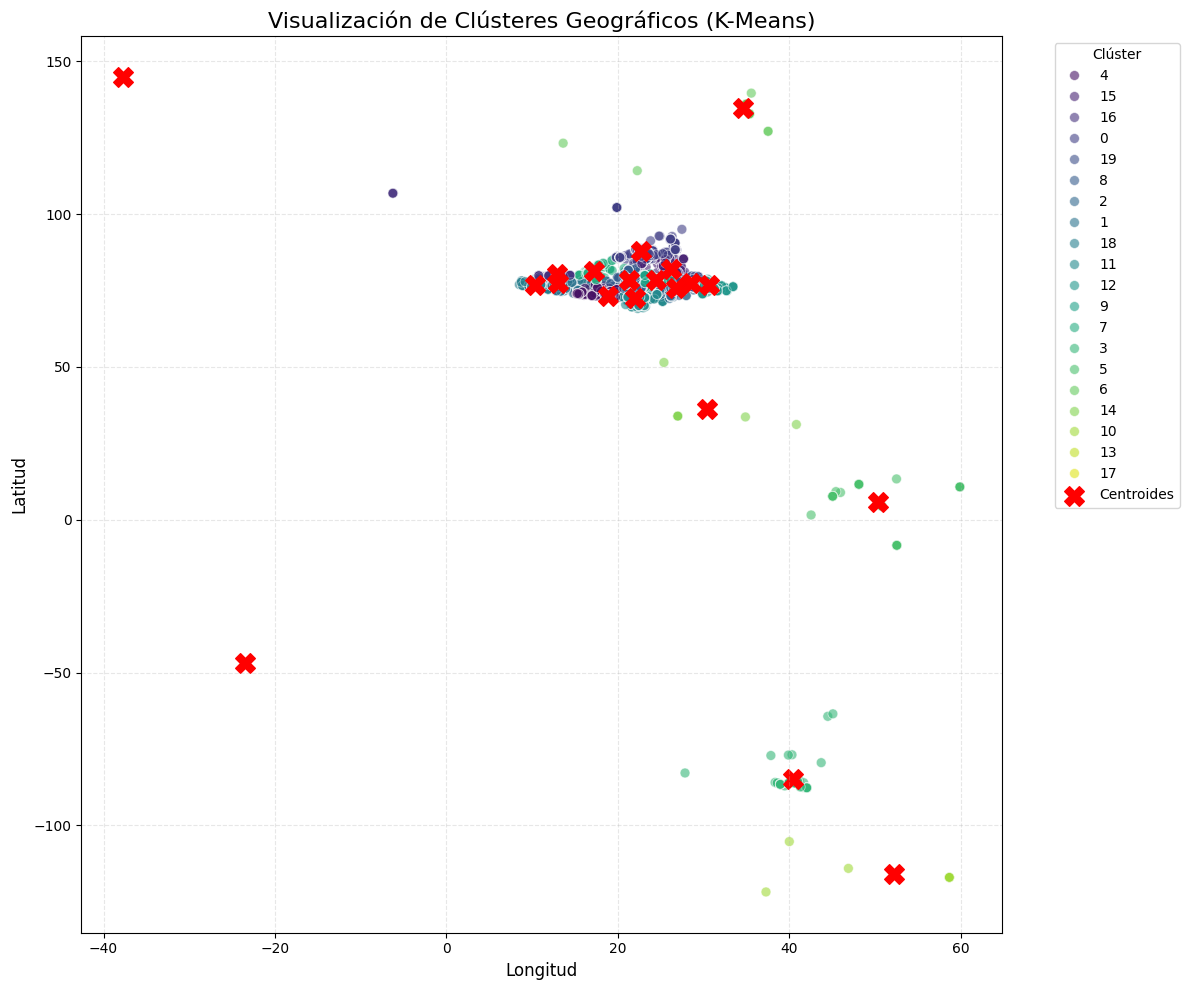

In [111]:
plt.figure(figsize=(12, 10))

sns.scatterplot(
    x=X_train[geo_cols[0]],
    y=X_train[geo_cols[1]],
    hue=X_train['GEO_CLUSTER'],
    palette='viridis',
    s=50,
    alpha=0.6,
    legend='full'
)

centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1], 
    marker='X', 
    s=200,  
    c='red',
    label='Centroides'
)

plt.title('Visualización de Clústeres Geográficos (K-Means)', fontsize=16)
plt.xlabel('Longitud', fontsize=12)
plt.ylabel('Latitud', fontsize=12)
plt.legend(title='Clúster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout() 

plt.show()

<h2 style="color: #3498DB">Feature Engineering - Parte 2</h2>

Aqui usamos ColumnTransformer para aplicar todas las transformaciones en un solo paso. Esto nos permite aplicar las transformaciones necesarias a las columnas correctas. <br>
Aplicamos OneHotEncoder a las variables previamente seapradas en la lista variables_ohe. Esto es para crear columnas numericas binarias a partir de columnas categoricas. <br>
Aplicamos StandarScaler a las varaibles continuas para darles media 0 y desviacion estandar 1. Esto sirve para evitar que varaibles con rangos mas grades dominen sobre las que tiene rangos mas chicos. <br>
variables_passthrough son las variable a las que no se le aplican cambios.

In [112]:
preprocesador = ColumnTransformer(
    transformers=[
        ('ohe_branch', 
         OneHotEncoder(handle_unknown='ignore', sparse_output=True), 
         variables_ohe),
       
        ('numeric_branch', 
         StandardScaler(), 
         variables_continuas),
        
        ('passthrough_branch', 
         'passthrough', 
         variables_passthrough)
    ],
    remainder='drop', #Si la columna no fue mencionada, se elimina
    verbose_feature_names_out=False
)

<h2 style="color: #3498DB">Evaluacion de Modelos</h2>

Primero creamos instancias de las clases de los modelos con configuraciones basicas. Creamos un lista con los modelos a evaluar. Iniciamos un bucle para probar los modelos, el cual incluye un pipeline que primero ejecuta el preprocesador (transoforma las varaibles) y luego el modelo. A ese pipeline creado se lo entrena con los datos de entrenamineto y luego se precide con los datos de testeo. y_pred genera predicciones a escala logaritmica. Se calculan las metricas de evaluacion comparando los datos de testeo y los datos predichos a escala logaritmica. Tambien se precide a escala normal y se muestran las metricas para verficar que el entrenameinto a escala logaritmica sirve para la escala normal. Guardamos los datos en un dataframe y los imprimimos. Ademas guardamos los datos del ejor modelo para buscar sus mejores hiperparametros.

In [115]:
model_gbr = GradientBoostingRegressor(random_state=42, learning_rate=0.1, max_depth=3, n_estimators=200)
model_rf = RandomForestRegressor(random_state=42, n_estimators=100, n_jobs=-1)
model_et = ExtraTreesRegressor(random_state=42, n_estimators=100, n_jobs=-1)
model_bag = BaggingRegressor(random_state=42, n_estimators=100, n_jobs=-1)

modelos = [
    (model_et, "Extra Trees Regressor", "Ensemble (Bagging)"),
    (model_rf, "Random Forest", "Ensemble (Bagging)"),
    (model_bag, "Bagging Regressor", "Ensemble (Bagging)"),
    (model_gbr, "Gradient Boosting", "Boosting"),
]

resultados = []
instancia_mejor_modelo = None
nombre_mejor_modelo = ""
mejor_r2_log_inicial = -np.inf # Usamos R2 en escala log para seleccionar el mejor modelo

y_test_original = np.expm1(y_test)

for modelo, nombre, tipo in modelos:
    print(f"Evaluando: {nombre} (Tipo: {tipo}) ---")

    full_pipeline = Pipeline(steps=[
        ('preprocessor', preprocesador),
        ('model', modelo)
    ])

    full_pipeline.fit(X_train, y_train)
    y_pred_log = full_pipeline.predict(X_test)
    y_pred_original = np.expm1(y_pred_log)

    mae_log = mean_absolute_error(y_test, y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
    r2_log = r2_score(y_test, y_pred_log)

    mae_orig = mean_absolute_error(y_test_original, y_pred_original)
    rmse_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
    r2_orig = r2_score(y_test_original, y_pred_original)

    resultados.append({
        "Tipo": tipo,
        "Modelo": nombre,
        "MAE_Orig": mae_orig,
        "RMSE_Orig": rmse_orig,
        "R2_Orig": r2_orig,
        "MAE_Log": mae_log,
        "RMSE_Log": rmse_log,
        "R2_Log": r2_log,
    })

    if r2_log > mejor_r2_log_inicial:
        mejor_r2_log_inicial = r2_log
        nombre_mejor_modelo = nombre
        instancia_mejor_modelo = modelo

df_resultados = pd.DataFrame(resultados)

df_ordenado_log = df_resultados.sort_values(by="R2_Log", ascending=False)
print("\nResultados de Evaluación Inicial (Ordenados por R² en Escala Log):")
print(df_ordenado_log[['Tipo', 'Modelo', 'MAE_Orig', 'RMSE_Orig', 'R2_Orig', 'R2_Log']])

if nombre_mejor_modelo:
     print(f"\nMejor modelo inicial basado en R² (Log): {nombre_mejor_modelo}")

Evaluando: Extra Trees Regressor (Tipo: Ensemble (Bagging)) ---
Evaluando: Random Forest (Tipo: Ensemble (Bagging)) ---
Evaluando: Bagging Regressor (Tipo: Ensemble (Bagging)) ---
Evaluando: Gradient Boosting (Tipo: Boosting) ---

Resultados de Evaluación Inicial (Ordenados por R² en Escala Log):
                 Tipo                 Modelo   MAE_Orig  RMSE_Orig   R2_Orig  \
2  Ensemble (Bagging)      Bagging Regressor  20.242744  46.750931  0.817182   
1  Ensemble (Bagging)          Random Forest  20.288016  46.909302  0.815941   
0  Ensemble (Bagging)  Extra Trees Regressor  20.735943  47.731788  0.809430   
3            Boosting      Gradient Boosting  25.691110  56.425272  0.733691   

     R2_Log  
2  0.843664  
1  0.843461  
0  0.829611  
3  0.804587  

Mejor modelo inicial basado en R² (Log): Bagging Regressor


<h2 style="color: #3498DB">Tuneo de Hiperparametros</h2>

Aqui usamos GridSearchCV para encontrar los mejores hiperparatros del modelo con mayor r2 en escala logaritmica y aumentar aun mas su rendimiento.

In [116]:
instancia_modelo_para_tuning = BaggingRegressor(random_state=42, n_jobs=-1)

pipeline_tuning = Pipeline(steps=[
    ('preprocessor', preprocesador),
    ('model', instancia_modelo_para_tuning)
])

grilla_parametros = {
    'model__n_estimators': [100, 200, 300]
}

if grilla_parametros:
    busqueda_grilla = GridSearchCV(
        pipeline_tuning,
        grilla_parametros,
        cv=3,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )

    busqueda_grilla.fit(X_train, y_train)

    print(f"\nMejor puntuación R² (Log Scale): {busqueda_grilla.best_score_:.4f}")
    print("Mejores Hiperparámetros encontrados:")

    for parametro, valor in busqueda_grilla.best_params_.items():
        print(f"  {parametro}: {valor}")

    mejor_modelo_tuneado = busqueda_grilla.best_estimator_

Fitting 3 folds for each of 3 candidates, totalling 9 fits

Mejor puntuación R² (Log Scale): 0.8393
Mejores Hiperparámetros encontrados:
  model__n_estimators: 300


<h2 style="color: #3498DB">Resultados mejor modelo</h2>

Imprimimos las metricas del modelo prediciendo datos en escala normal.

In [117]:
y_pred_log_final = mejor_modelo_tuneado.predict(X_test)

y_pred_original_final = np.expm1(y_pred_log_final)
y_test_original = np.expm1(y_test)

r2_final_orig = r2_score(y_test_original, y_pred_original_final)
mae_final_orig = mean_absolute_error(y_test_original, y_pred_original_final)
rmse_final_orig = np.sqrt(mean_squared_error(y_test_original, y_pred_original_final))

print(f"R² (Original): {r2_final_orig:.4f}")
print(f"MAE (Original): {mae_final_orig:.2f}")
print(f"RMSE (Original): {rmse_final_orig:.2f}")

R² (Original): 0.8195
MAE (Original): 20.15
RMSE (Original): 46.46


<h2 style="color: #3498DB">Grafico de residuos</h2>

Aqui usamos el mejor modelo encontrado para predecir en escala logaritmica. Luego se crea un grafico que muestra los errores contra las predicciones llamado grafico de residuos. La idea de este grafico es que los puntos de scatter plot se situen de forma aleatoria alrededor de la linea roja (y=0) sin patrones obvios.<br> 
Al final revertimos la transformacion logaritmica para obtener los valores reales y poder calcular R2, MAE y RMSE en escala original.

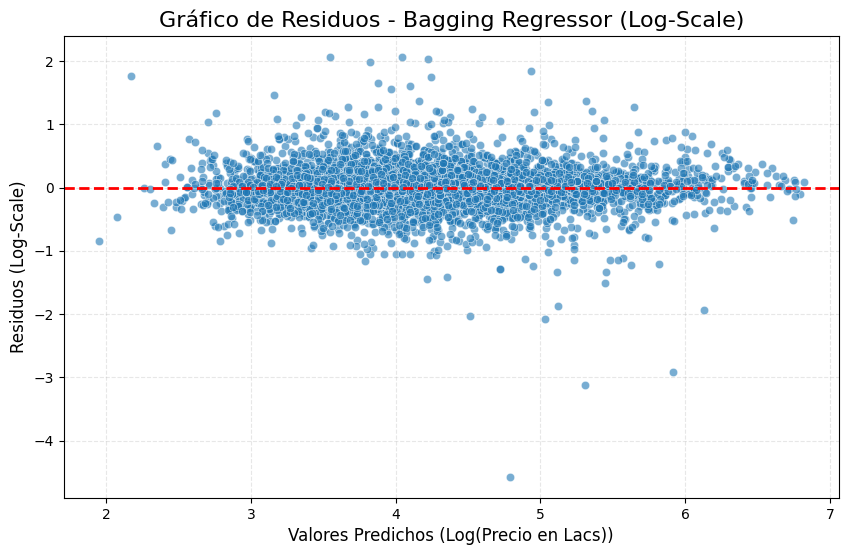

In [118]:
residuals_log = y_test - y_pred_log_final

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_log_final, y=residuals_log, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.title(f'Gráfico de Residuos - Bagging Regressor (Log-Scale)', fontsize=16)
plt.xlabel('Valores Predichos (Log(Precio en Lacs))', fontsize=12)
plt.ylabel('Residuos (Log-Scale)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

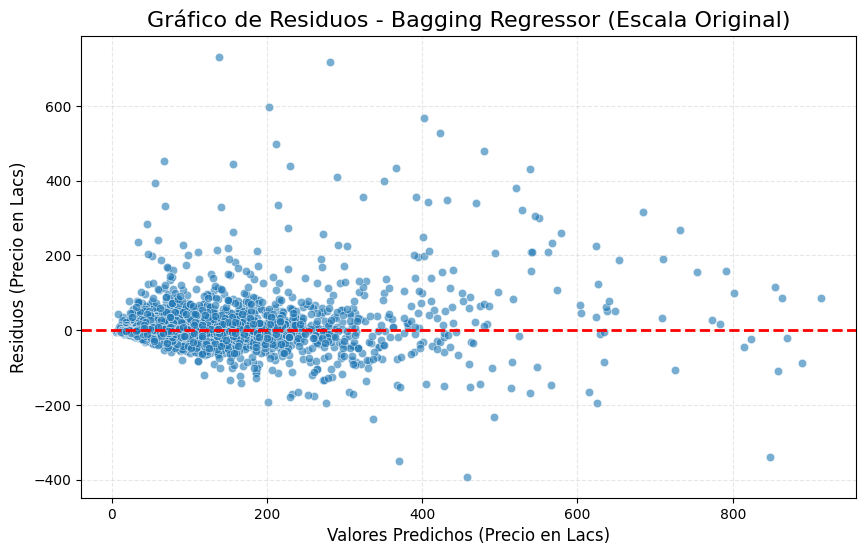

In [119]:
residuals_orig = y_test_original - y_pred_original_final

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_original_final, y=residuals_orig, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)

plt.title(f'Gráfico de Residuos - Bagging Regressor (Escala Original)', fontsize=16)
plt.xlabel('Valores Predichos (Precio en Lacs)', fontsize=12)
plt.ylabel('Residuos (Precio en Lacs)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

<h2 style="color: #3498DB">Conclusión</h2>

Procesimientos aplicados: <br>
-Se logro extraer la ciudad y el barrio de la varaible ADDRESS para obtener informacion util para el modelo.<br>
-Se aplico transformacion logaritmica a ciertas varaibles para disminuir el sesgo presente.<br>
-Se redujo la dimensionalidad de las variables CITY y barrio para que el one hot encoder sea mas efectivo.<br>
-Se aplico una tecnica de clusering llamada KMeans para obtener zonas segun las cordenadas de latitud y longitud.<br>
-Se eliminaron los outliers para mejorar el modelado de los datos.<br>
-Se aplico OneHotEncoder para obtener varaibles numericas binarias a partir de variables categoricas.<br>
-Se aplica StandardScaler para reducir la desvicion y media de los datos.<br>
-Se aplico ColumnTransformer para escribir codigo mas limpio y eficiente.<br>
-Se entrenaron cuatro modelos de machine learning utilizando Pipelines.<br>
-Se busco los mejores hiperparametros para el modelo con el mayor rendimiento.<br>
-Se realizaron los graficos de residuos tanto en escala logaritmica como normal.<br>
<br>
Modelado y resultados: <br>
Luego de entrenar los cuatro modelos de la machine learning se encontro que el modelo de BaggingRegressor fue el que mejor metricas dio con MAE=20.24, RMSE=46.75 y R2=0.81 en escala normal. Luego del tuneo de hiperparametros el rendimiento ya que R2=0.8195 mientras que MAE y RMSE bajaron apenas, lo cual es una buena señal.<br>
<br>
Analisis de Residuos:<br>
Segun el grafico de residuos, la escala logaritmica dio buenos resultados mostrando una distribucion aleatoria y homocedrastica indicando nu buen ajuste.<br>
Sin embargo, en escala normal dio un grafico tipo embudo lo cual indica heterocedasticidad. Esto es comun al revertir la transformacion logaritmica pero igualmente indica una menor presicion en prediciones en escala normal.<br>
<br>
Sintesis:<br>
El mejor modelo fue BaggingRegressor con un r2=0.8195. Las tecnicas de feature engineering, clustering, transformacion y reduccion de dimensionalidad fueron claves para mejorar la calidad del modelo aunque persiste una menor presicion en predicciones de casas de precios altos en escala original.